In [21]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

import keras
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [4]:
os.chdir('drive/MyDrive')
os.getcwd()

'/content/drive/MyDrive'

## Getting all the Words
- We will get all the words used in the description.txt file
- This file contains descriptions of images used for the training purpose

In [30]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "Image Captioning - Infosys/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [31]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = 'Image Captioning - Infosys/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [32]:
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('Image Captioning - Infosys/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [10]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [11]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [12]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

# Model for Feature Extraction
- This model is used to extract features from the images
- We will use inceptionV3 to extract features
- We will also remove the last two output layers of this model, but will add another trained model to generate captions
- So raw_image -> InceptionV3 (for Feature Extraction) -> GreedySearch ( Pretrained Model for image captioning )

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model

In [25]:
model_incp = InceptionV3(weights='imagenet')

In [26]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_incp_new = Model(model_incp.input, model_incp.layers[-2].output)

# Greedy Search

In [23]:
max_length = 34 # this has been calculated from the descriptions.txt

In [13]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

# Making Predictions

In [33]:
# Loading Pretrained Model
model = keras.models.load_model('Image Captioning - Infosys/image_capt_model.h5')

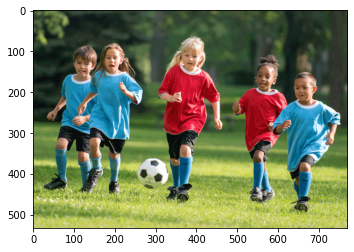

Greedy: two boys play soccer on the grass


In [37]:
img = Image.open("Image Captioning - Infosys/Sample_test_images/image1.jpg")
newImg = img.resize((299,299), Image.BILINEAR).convert("RGB")
data = np.array( newImg.getdata() )
input=( data.reshape( (1, newImg.size[0], newImg.size[1], 3) ).astype( np.float32 )/255 ) - 1
image= model_incp_new.predict(input) # Get the encoding vector for the image
x=plt.imread("Image Captioning - Infosys/Sample_test_images/image1.jpg")
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))